In [1]:
%load_ext autoreload

In [65]:
%autoreload 2
from delase import DeLASE
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import torch

from UniversalUnconsciousness.data_utils import get_grid_params_to_use,get_noise_filter_info, get_pca_chosen, collect_grid_indices_to_run
from UniversalUnconsciousness.hdf5_utils import *

In [5]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [245]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
cfg.params.data_class = 'propofolPuffTone'
session = "Mary-Anesthesia-20160912-02"


cfg.params.data_class = 'anesthesiaLvrOdd'
# session = "SPOCK_Ketamine_20210827" # dose = 1.0
# session = "SPOCK_Ketamine_20210902" # dose = 1.0
session = "SPOCK_Ketamine_20210712" # dose = 10.0

In [246]:
cfg.params.pca = False

In [247]:
# propofol dir
if cfg.params.data_class == 'propofolPuffTone':
    data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)
else:
    data_dir = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')


In [248]:


# 
# session = "SPOCK_Ketamine_20210712"

session_list = [session]
areas = ['all']

In [249]:
noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=True)

28 bad electrodes, 1068 valid windows (out of 1513 total windows)


In [250]:
pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=False)
all_indices_to_run = collect_grid_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=False)


In [251]:
grid_params_to_use = get_grid_params_to_use(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=False)

In [252]:
session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

In [253]:
session_file['sessionInfo']['dose'][0, 0]

np.float64(10.0)

In [254]:
lfp = TransposedDatasetView(session_file['lfp']).transpose()
dt = session_file['lfpSchema']['smpInterval'][0, 0]
if cfg.params.data_class == 'propofolPuffTone':
    infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
else:
    infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]


In [255]:
wake_t = (infusion_start - 10*60)
anesthesia_t = (infusion_start + 20*60)

In [256]:
wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(wake_t - noise_filter_info[session]['valid_window_starts']))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(anesthesia_t - noise_filter_info[session]['valid_window_starts']))]


In [257]:
bad_electrodes = noise_filter_info[session]['bad_electrodes']
valid_electrodes = [i for i in range(lfp.shape[1]) if i not in bad_electrodes]

In [321]:
subsample_factor = 1
scale_time = False
window = 15*subsample_factor if scale_time else 15
lfp_w = lfp[int(wake_window_start/dt):int((wake_window_start + window)/dt), valid_electrodes]
lfp_a = lfp[int(anesthesia_window_start/dt):int((anesthesia_window_start + window)/dt), valid_electrodes]
lfp_w = lfp_w[::subsample_factor]
lfp_a = lfp_a[::subsample_factor]
lfp_w.shape, lfp_a.shape

((15000, 100), (15000, 100))

In [322]:
area = areas[0]
n_delays, rank = grid_params_to_use[session][area]['n_delays'], grid_params_to_use[session][area]['rank']

In [323]:
delase_w = DeLASE(lfp_w, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_a = DeLASE(lfp_a, n_delays=n_delays, rank=rank, dt=dt, device='cuda')

In [324]:
delase_w.fit()
delase_a.fit()

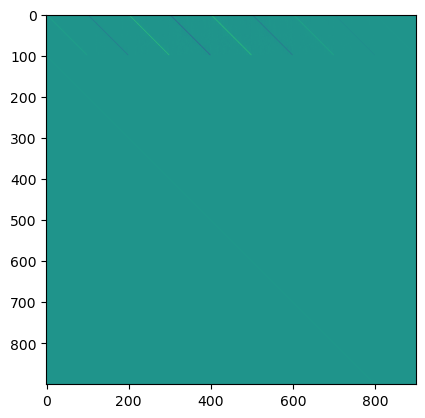

In [325]:
plt.imshow(delase_w.DMD.A_havok_dmd.cpu().numpy())
plt.imshow(delase_a.DMD.A_havok_dmd.cpu().numpy())
plt.show()

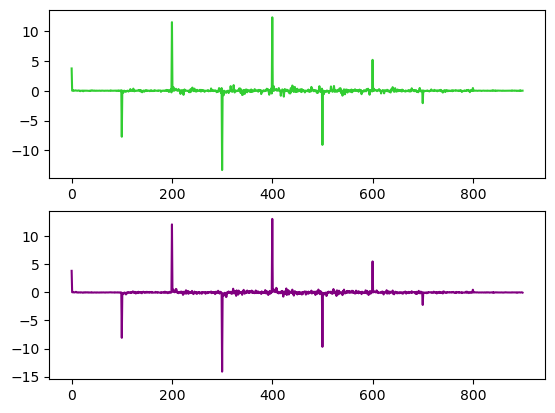

In [326]:

plt.subplot(2,1,1)
plt.plot(delase_w.DMD.A_havok_dmd[0].cpu().numpy(), c='limegreen')
plt.subplot(2,1,2)
plt.plot(delase_a.DMD.A_havok_dmd[0].cpu().numpy(), c='purple')
plt.show()

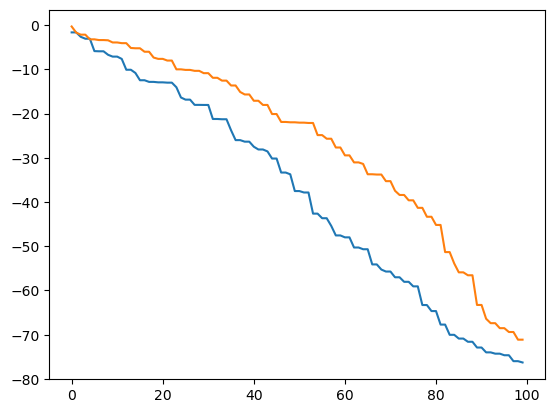

In [327]:
plt.plot(delase_w.stability_params[:int(0.1*len(delase_w.stability_params))].cpu().numpy())
plt.plot(delase_a.stability_params[:int(0.1*len(delase_a.stability_params))].cpu().numpy())
plt.show()

In [217]:
lfp_w_pred = delase_w.DMD.predict(lfp_w)
lfp_a_pred = delase_a.DMD.predict(lfp_a)

In [218]:
from delase.metrics import mase

In [219]:
mase(lfp_w, lfp_w_pred.cpu().numpy()), mase(lfp_a, lfp_a_pred.cpu().numpy())

(np.float64(0.2376163531148324), np.float64(0.23172622322407269))